# Ultimate Technologies Inc. - Take Home Challenge

## Part 1 - Exploratory Data Analysis

In [122]:
# Import modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose

In [123]:
# Load data
logins = pd.read_json('logins.json')

In [124]:
# Inspect logins
logins.head()

login_time
0 1970-01-01 20:13:18
1 1970-01-01 20:16:10
2 1970-01-01 20:16:37
3 1970-01-01 20:16:36
4 1970-01-01 20:26:21

In [125]:
# Sort values to ensure they are in sequential order
logins.sort_values('login_time', inplace=True)

In [126]:
# Check info for null values and dtype
logins.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 93142 entries, 6 to 93140
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   login_time  93142 non-null  datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 1.4 MB


No null values

In [127]:
# Set datetime column to index
logins.set_index('login_time', inplace=True)

In [128]:
# Create column of 1's representing a log-in in at that time
logins['LoginFreq']=1

### By 15 Minute Intervals

In [129]:
# Resample 
logins = logins.resample('15min').count()

In [130]:
logins['weekday'] = logins.index.day_name()

In [131]:
logins.head()

LoginFreq   weekday
login_time                              
1970-01-01 20:00:00          2  Thursday
1970-01-01 20:15:00          6  Thursday
1970-01-01 20:30:00          9  Thursday
1970-01-01 20:45:00          7  Thursday
1970-01-01 21:00:00          1  Thursday

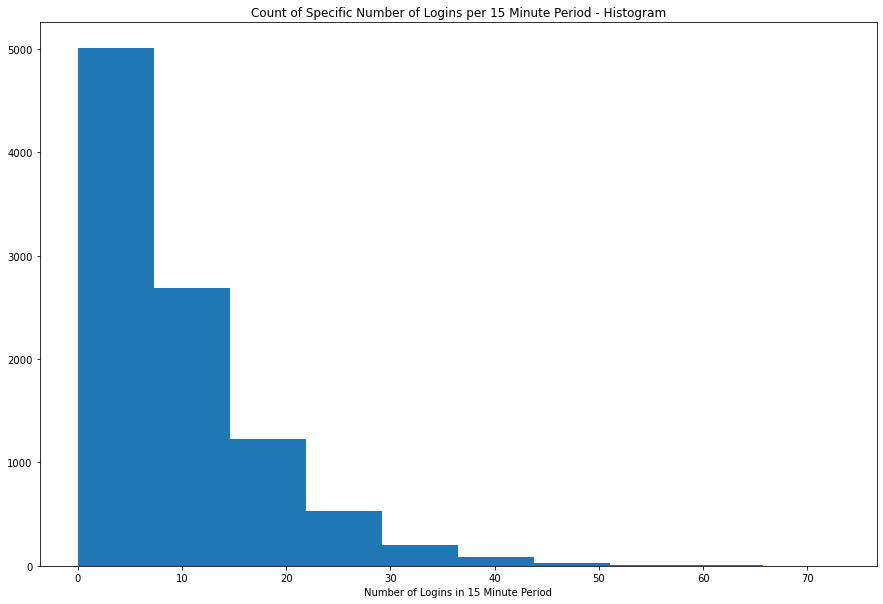

In [133]:
# Plot histogram of logins per 15 minute period
_ = plt.figure(figsize=(15,10))
_ = plt.hist(logins['LoginFreq'])
_ = plt.title('Count of Specific Number of Logins per 15 Minute Period - Histogram')
_ = plt.xlabel('Number of Logins in 15 Minute Period')

Data are skewed

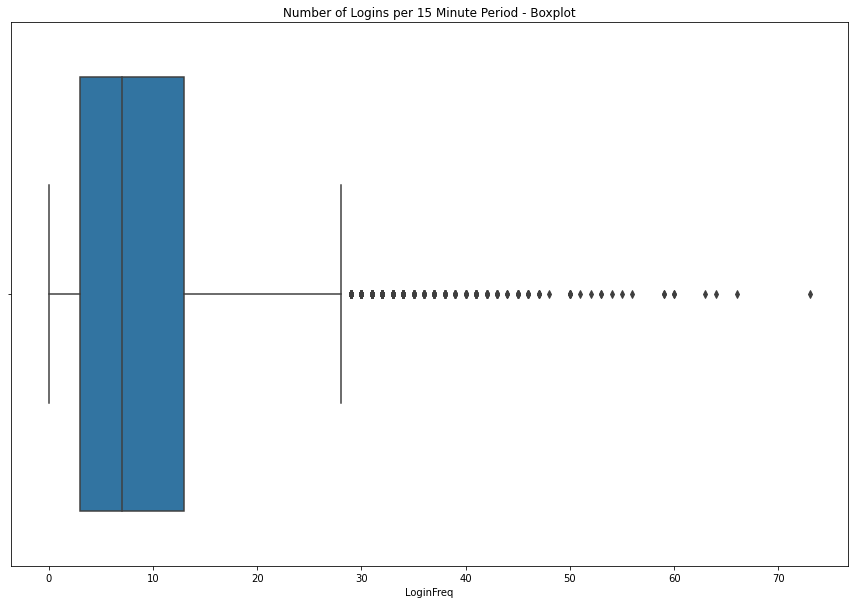

In [13]:
# Plot boxplot of logins per 15 minute period
_ = plt.figure(figsize=(15,10))
_ = sns.boxplot(data=logins, x='LoginFreq')
_ = plt.title('Number of Logins per 15 Minute Period - Boxplot')

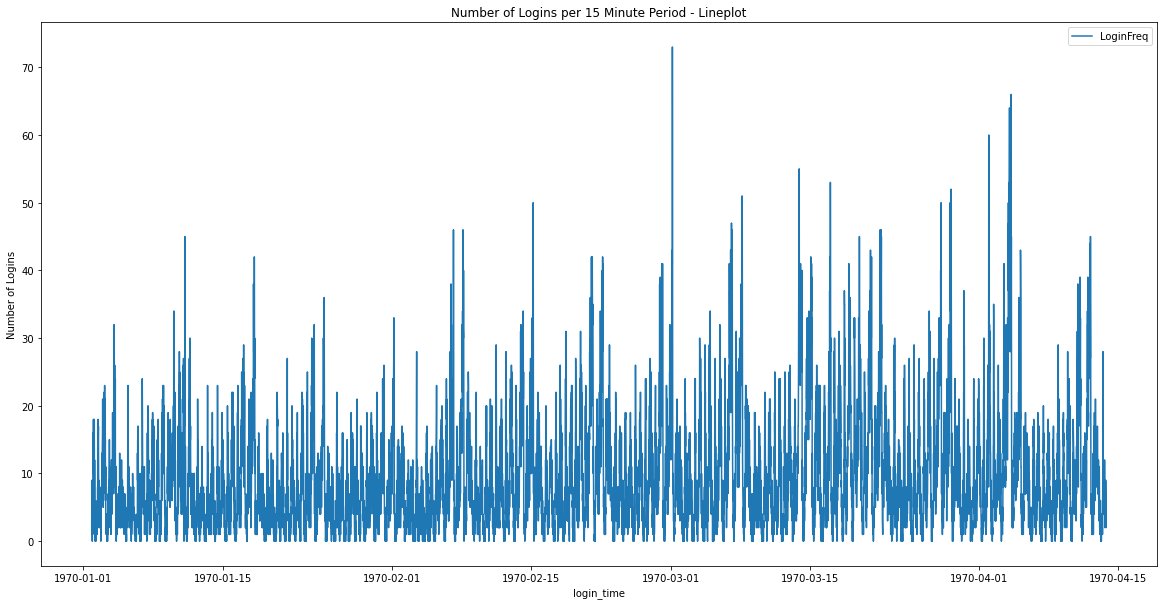

In [14]:
# Plot full data
_ = plt.figure(figsize=(20,10))
_ = sns.lineplot(data=logins)
_ = plt.title('Number of Logins per 15 Minute Period - Lineplot')
_ = plt.ylabel('Number of Logins')
plt.show()

Perform seasonal decomposition on weeklong periods

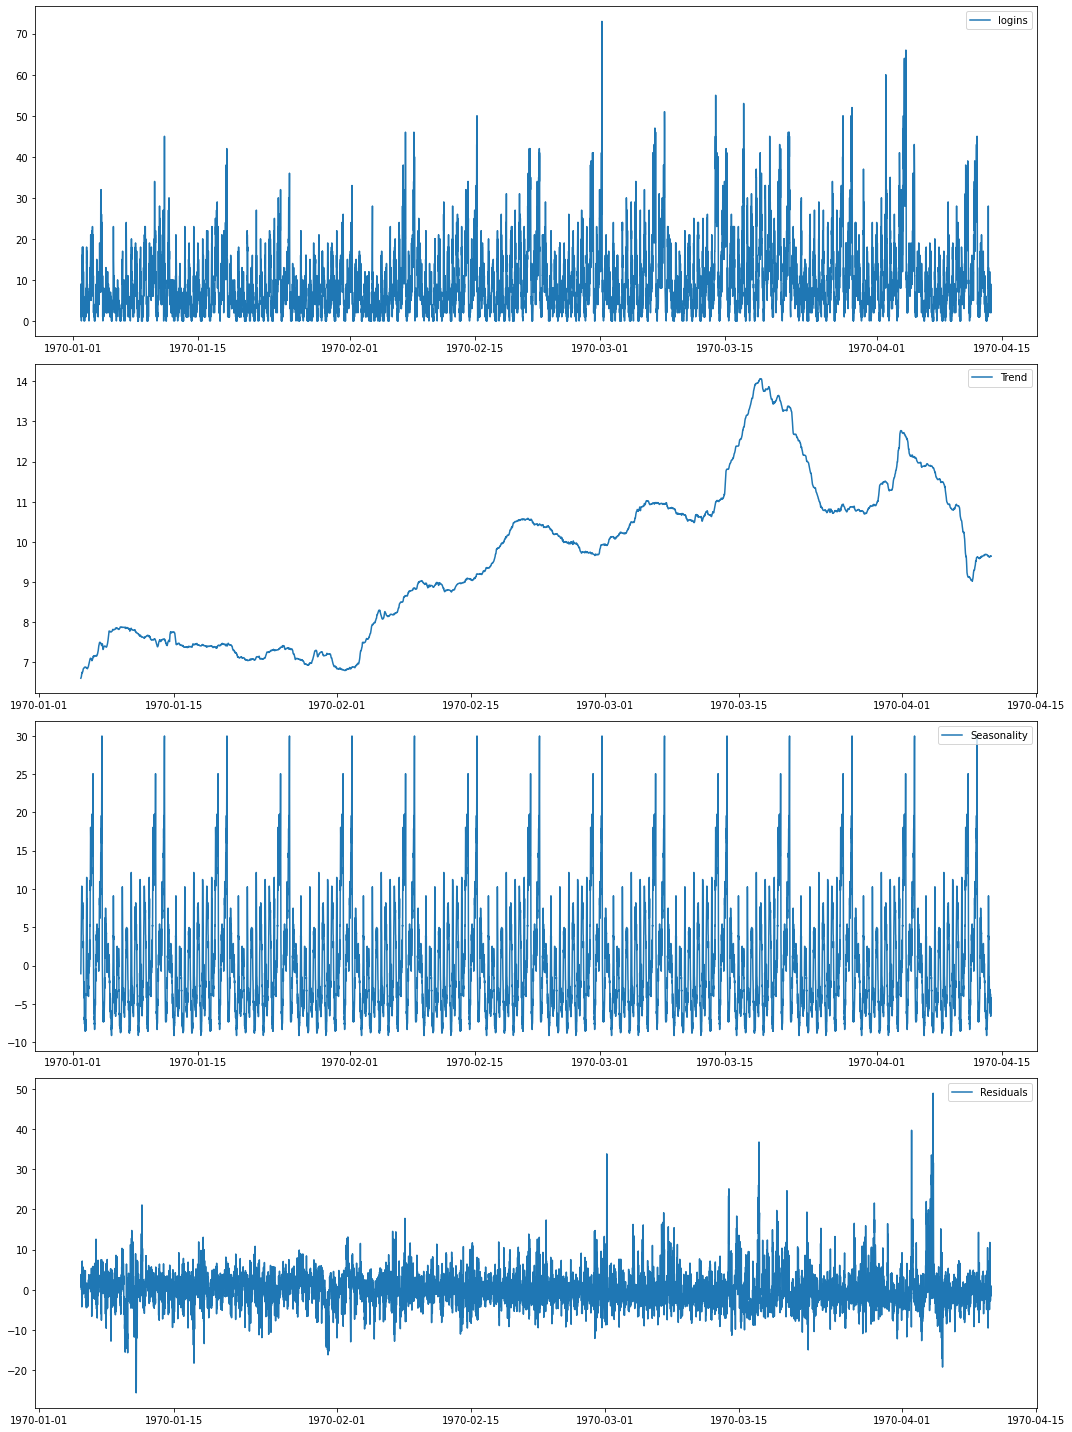

In [15]:
# Decompose time-series
decomposition = seasonal_decompose(logins['LoginFreq'], model='additive', period=(4*24*7))

# Extract parameters
trend = decomposition.trend
weekseasonality = decomposition.seasonal
res = decomposition.resid

# Plot the original data, the trend, the seasonality, and the residuals 
_ = plt.figure(figsize=(15,20))
_ = plt.subplot(411)
_ = plt.plot(logins['LoginFreq'], label = 'logins')
_ = plt.legend(loc = 'best')
_ = plt.subplot(412)
_ = plt.plot(trend, label = 'Trend')
_ = plt.legend(loc = 'best')
_ = plt.subplot(413)
_ = plt.plot(weekseasonality, label = 'Seasonality')
_ = plt.legend(loc = 'best')
_ = plt.subplot(414)
_ = plt.plot(res, label = 'Residuals')
_ = plt.legend(loc = 'best')
_ = plt.tight_layout()

- There is a clear seasonality for weeklong periods as well as a trend observed. Without data spanning over at least two years, it is impossible to tell if the apparent "trend" is meaningful or just representative of seasonality over the year.

Zoom in on seasonality over the week

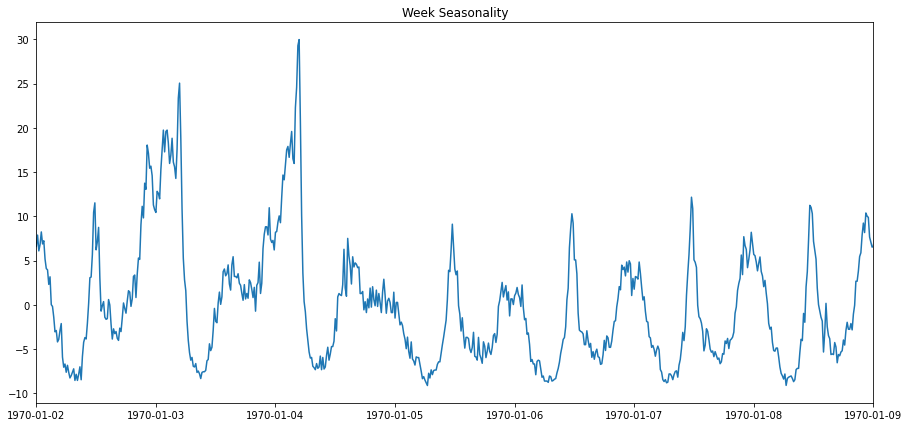

In [16]:
# Zoom in on weekly seasonality for time-series
_ = plt.figure(figsize=(15,7))
_ = plt.plot(weekseasonality)
_ = plt.title('Week Seasonality')
_ = plt.xlim('1970-01-02', '1970-01-09')
plt.show()

In [17]:
# Print weekdays that 1970-01-02 through 1970-01-04 occur on
print(logins.loc['1970-01-02':'1970-01-04'].weekday.unique())

['Friday' 'Saturday' 'Sunday']


- Friday and Saturday nights have large spikes. This represents the surge in people requesting ride-share services for weekend nightlife.

Decompose by daily periods and inspect the daily seasonality

In [18]:
# Decompose time-series
daydecomposition = seasonal_decompose(logins['LoginFreq'], model='additive', period=(4*24))

# Extract parameters
dayseasonality = daydecomposition.seasonal

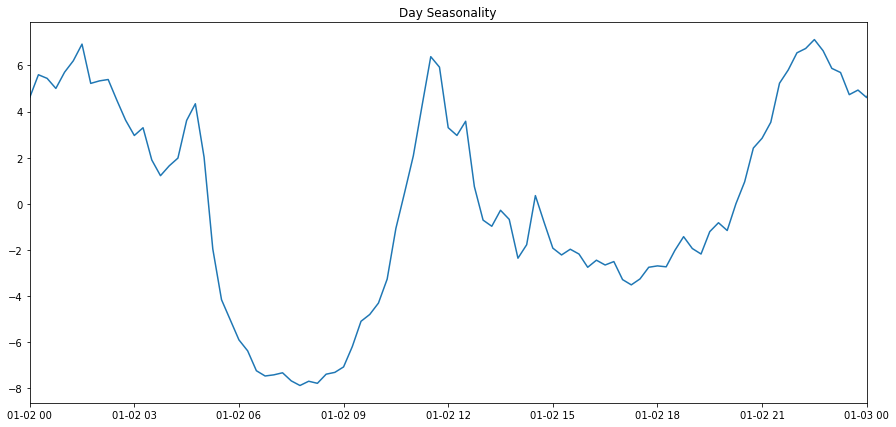

In [19]:
# Zoom in on day seasonality for time-series
_ = plt.figure(figsize=(15,7))
_ = plt.plot(dayseasonality)
_ = plt.title('Day Seasonality')
_ = plt.xlim('1970-01-02', '1970-01-03')
plt.show()

- There is a drop in requests between 5 and 9 am, with a spike between 9 and noon. There's a bit of a lull from noon to 6 pm, afterwhich there is a spike taking it through to midnight.

## Part 2 - Experiment and Metrics Design

###### Scenario:
- There is a two-way toll bridge between two nearby major cities resulting in drivers primarily working within one city at a time. It is in the best interest of the company to have the maximum number of drivers available for both cities at all times.

###### Proposed action:
- Reimburse all toll costs to drivers.

###### Null Hypothesis:
- Reimbursing toll costs to drivers will not result in increased driver activity between cities.

###### Key Success Metric:
 - Appropriate metric would reflect the ratio of rides given in city A vs city B, with a goal to minimize the difference between the two.
 - a = total rides given in city a in a day
 - b = total rides given in city b in a day
 - success metric = |(b - a) / (b + a)|
 
###### Experiment:
- A/B test on balanced sample of drivers. Total sample pool should have at least 100 drivers.
- Driver sample will reflect an equal number of drivers based in both cities. Day/Night and Weekday/Weekend drivers will be equaly represented in sampling as well. Selected drivers must drive at least 20 hours a week on average.
- Split driver sample in half. Offer one half reimbursed tolls (test group) and do nothing for other half (control group).
- Log success metrics for each driver for one month.
- Calculate mean metric for the test group.
- Determine estimate of normal distribution for the control group.
- Perform p-test to determine if null hypothesis can be rejected. Use standard p-value of 0.05 as indicator of significance, unless there is rationale to do otherwise. Depending on the distribution of the data, this may need to be adjusted.
- Note that the null hypothesis can only be rejected if the test group mean ends up on the left side of the control group distribution.

###### Interpretation:
- If the null hypopthesis is not rejected, it is possible that providing reimbursements to drivers is still not at ideal solution. 
- If that is the case, perhaps a deal can be made with the city wherein Ultimate is charged directly for driver tolls rather than the drivers being charged and subsequently reimbursed. Some drivers may not be financially willing to be charged directly for tolls even if they will be reimbursed by Ultimate. This could come in the form of Ultimate toll tags which can be billed directly by the city.
- It is also possible that the length of the experiment may not be long enough for drivers to adjust their driving patterns. Considerations should be made for extending the length of the experiment to 6 - 12 months in order to collect more meaningful data. Look for driving patterns to converge after a period of time.

## Part 3 - Predictive Modeling

In [68]:
# Load data
df = pd.read_json('ultimate_data_challenge.json')

### Data Wrangling

In [69]:
df.head()

city  trips_in_first_30_days signup_date  avg_rating_of_driver  \
0  King's Landing                       4  2014-01-25                   4.7   
1         Astapor                       0  2014-01-29                   5.0   
2         Astapor                       3  2014-01-06                   4.3   
3  King's Landing                       9  2014-01-10                   4.6   
4      Winterfell                      14  2014-01-27                   4.4   

   avg_surge last_trip_date    phone  surge_pct  ultimate_black_user  \
0       1.10     2014-06-17   iPhone       15.4                 True   
1       1.00     2014-05-05  Android        0.0                False   
2       1.00     2014-01-07   iPhone        0.0                False   
3       1.14     2014-06-29   iPhone       20.0                 True   
4       1.19     2014-03-15  Android       11.8                False   

   weekday_pct  avg_dist  avg_rating_by_driver  
0         46.2      3.67                   5.0  
1         50.0      8.26                   5.0  
2        100.0      0.77                   5.0  
3         80.0      2.36                   4.9  
4         82.4      3.13                   4.9

In [70]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    50000 non-null  object 
 1   trips_in_first_30_days  50000 non-null  int64  
 2   signup_date             50000 non-null  object 
 3   avg_rating_of_driver    41878 non-null  float64
 4   avg_surge               50000 non-null  float64
 5   last_trip_date          50000 non-null  object 
 6   phone                   49604 non-null  object 
 7   surge_pct               50000 non-null  float64
 8   ultimate_black_user     50000 non-null  bool   
 9   weekday_pct             50000 non-null  float64
 10  avg_dist                50000 non-null  float64
 11  avg_rating_by_driver    49799 non-null  float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


In [71]:
# Convert columns to datetime
df['signup_date'] = pd.to_datetime(df['signup_date'])
df['last_trip_date'] = pd.to_datetime(df['last_trip_date'])

#### Generate labels

In [72]:
# Generate retained column (i.e. y values)
df['retained'] = df['last_trip_date'].apply(lambda x: 1 if x >= pd.to_datetime('2014-06-01') else 0)

In [73]:
# Change dtype of retained column to bool
df['retained'] = df['retained'].astype('bool')

In [74]:
df.head()

city  trips_in_first_30_days signup_date  avg_rating_of_driver  \
0  King's Landing                       4  2014-01-25                   4.7   
1         Astapor                       0  2014-01-29                   5.0   
2         Astapor                       3  2014-01-06                   4.3   
3  King's Landing                       9  2014-01-10                   4.6   
4      Winterfell                      14  2014-01-27                   4.4   

   avg_surge last_trip_date    phone  surge_pct  ultimate_black_user  \
0       1.10     2014-06-17   iPhone       15.4                 True   
1       1.00     2014-05-05  Android        0.0                False   
2       1.00     2014-01-07   iPhone        0.0                False   
3       1.14     2014-06-29   iPhone       20.0                 True   
4       1.19     2014-03-15  Android       11.8                False   

   weekday_pct  avg_dist  avg_rating_by_driver  retained  
0         46.2      3.67                   5.0      True  
1         50.0      8.26                   5.0     False  
2        100.0      0.77                   5.0     False  
3         80.0      2.36                   4.9      True  
4         82.4      3.13                   4.9     False

#### Generate feature for days between last_trip_date and signup_date

In [76]:
# Calculate days from signup to last trip
df['signup_to_last_trip'] = df['last_trip_date'] - df['signup_date']

In [77]:
# Convert to int type
df['signup_to_last_trip'] = df['signup_to_last_trip'].dt.days

In [78]:
df.head()

city  trips_in_first_30_days signup_date  avg_rating_of_driver  \
0  King's Landing                       4  2014-01-25                   4.7   
1         Astapor                       0  2014-01-29                   5.0   
2         Astapor                       3  2014-01-06                   4.3   
3  King's Landing                       9  2014-01-10                   4.6   
4      Winterfell                      14  2014-01-27                   4.4   

   avg_surge last_trip_date    phone  surge_pct  ultimate_black_user  \
0       1.10     2014-06-17   iPhone       15.4                 True   
1       1.00     2014-05-05  Android        0.0                False   
2       1.00     2014-01-07   iPhone        0.0                False   
3       1.14     2014-06-29   iPhone       20.0                 True   
4       1.19     2014-03-15  Android       11.8                False   

   weekday_pct  avg_dist  avg_rating_by_driver  retained  signup_to_last_trip  
0         46.2      3.67                   5.0      True                  143  
1         50.0      8.26                   5.0     False                   96  
2        100.0      0.77                   5.0     False                    1  
3         80.0      2.36                   4.9      True                  170  
4         82.4      3.13                   4.9     False                   47

#### Clean Data

- Null values

In [79]:
df.isnull().sum()

city                         0
trips_in_first_30_days       0
signup_date                  0
avg_rating_of_driver      8122
avg_surge                    0
last_trip_date               0
phone                      396
surge_pct                    0
ultimate_black_user          0
weekday_pct                  0
avg_dist                     0
avg_rating_by_driver       201
retained                     0
signup_to_last_trip          0
dtype: int64

There is a large amount of null values in avg_rating_of_driver. Check distribution. If std is low then replacing nulls with mean value might be appropriate.

In [80]:
df.avg_rating_of_driver.describe()

count    41878.000000
mean         4.601559
std          0.617338
min          1.000000
25%          4.300000
50%          4.900000
75%          5.000000
max          5.000000
Name: avg_rating_of_driver, dtype: float64

std is < 1.0. Inspect rows containing these nulls to make sure there's nothing inherently different about them.

In [81]:
df.loc[pd.isnull(df.loc[:, 'avg_rating_of_driver'])].describe()

trips_in_first_30_days  avg_rating_of_driver    avg_surge    surge_pct  \
count             8122.000000                   0.0  8122.000000  8122.000000   
mean                 0.593327                   NaN     1.078210     8.548067   
std                  0.606755                   NaN     0.310306    26.578461   
min                  0.000000                   NaN     1.000000     0.000000   
25%                  0.000000                   NaN     1.000000     0.000000   
50%                  1.000000                   NaN     1.000000     0.000000   
75%                  1.000000                   NaN     1.000000     0.000000   
max                  5.000000                   NaN     5.000000   100.000000   

       weekday_pct     avg_dist  avg_rating_by_driver  signup_to_last_trip  
count  8122.000000  8122.000000           8055.000000          8122.000000  
mean     59.050948     7.506267              4.785984            66.574489  
std      46.859739     7.758616              0.622122            59.837186  
min       0.000000     0.000000              1.000000             0.000000  
25%       0.000000     2.410000              5.000000             1.000000  
50%     100.000000     4.715000              5.000000            59.000000  
75%     100.000000    10.720000              5.000000           125.000000  
max     100.000000   160.960000              5.000000           181.000000

Most of these drivers didn't drive very much. It's likely that these null values legitimately represent a lack of ratings. Presumeably other columns like avg_dist and trips_in_first_30_days will impact the model much more than this column. Based on the low std of this column, it doesn't make sense that it would be one of the more important features.

In [84]:
# Fill column nulls
df['avg_rating_of_driver'].fillna(df['avg_rating_of_driver'].mean(), inplace=True)

In [86]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   city                    50000 non-null  object        
 1   trips_in_first_30_days  50000 non-null  int64         
 2   signup_date             50000 non-null  datetime64[ns]
 3   avg_rating_of_driver    50000 non-null  float64       
 4   avg_surge               50000 non-null  float64       
 5   last_trip_date          50000 non-null  datetime64[ns]
 6   phone                   49604 non-null  object        
 7   surge_pct               50000 non-null  float64       
 8   ultimate_black_user     50000 non-null  bool          
 9   weekday_pct             50000 non-null  float64       
 10  avg_dist                50000 non-null  float64       
 11  avg_rating_by_driver    49799 non-null  float64       
 12  retained                50000 non-null  bool  

The number of null values in avg_rating_by_driver and phone are few enough that it is acceptable to drop those rows entirely.

In [88]:
# Drop remaining rows with null values
df.dropna(inplace=True)

In [89]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49406 entries, 0 to 49999
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   city                    49406 non-null  object        
 1   trips_in_first_30_days  49406 non-null  int64         
 2   signup_date             49406 non-null  datetime64[ns]
 3   avg_rating_of_driver    49406 non-null  float64       
 4   avg_surge               49406 non-null  float64       
 5   last_trip_date          49406 non-null  datetime64[ns]
 6   phone                   49406 non-null  object        
 7   surge_pct               49406 non-null  float64       
 8   ultimate_black_user     49406 non-null  bool          
 9   weekday_pct             49406 non-null  float64       
 10  avg_dist                49406 non-null  float64       
 11  avg_rating_by_driver    49406 non-null  float64       
 12  retained                49406 non-null  bool  

- Check for duplicate rows

In [94]:
# Check duplicates
df.duplicated().sum()

8

There are 8 duplicate rows. Drop them.

In [95]:
# Drop duplicates
df.drop_duplicates(inplace=True)

In [96]:
# Verify success
df.duplicated().sum()

0

- Check for typos in categorical columns

In [102]:
df.city.unique()

array(["King's Landing", 'Astapor', 'Winterfell'], dtype=object)

In [103]:
df.phone.unique()

array(['iPhone', 'Android'], dtype=object)

Looks good

#### Generate Dummy Variables for categorical columns

In [107]:
# Generate dummy variables. Drop first to reduce cardinality.
df = pd.get_dummies(df, columns=['city', 'phone'], drop_first=True)

In [108]:
df.head()

trips_in_first_30_days signup_date  avg_rating_of_driver  avg_surge  \
0                       4  2014-01-25                   4.7       1.10   
1                       0  2014-01-29                   5.0       1.00   
2                       3  2014-01-06                   4.3       1.00   
3                       9  2014-01-10                   4.6       1.14   
4                      14  2014-01-27                   4.4       1.19   

  last_trip_date  surge_pct  ultimate_black_user  weekday_pct  avg_dist  \
0     2014-06-17       15.4                 True         46.2      3.67   
1     2014-05-05        0.0                False         50.0      8.26   
2     2014-01-07        0.0                False        100.0      0.77   
3     2014-06-29       20.0                 True         80.0      2.36   
4     2014-03-15       11.8                False         82.4      3.13   

   avg_rating_by_driver  retained  signup_to_last_trip  city_King's Landing  \
0                   5.0      True                  143                    1   
1                   5.0     False                   96                    0   
2                   5.0     False                    1                    0   
3                   4.9      True                  170                    1   
4                   4.9     False                   47                    0   

   city_Winterfell  phone_iPhone  
0                0             1  
1                0             0  
2                0             1  
3                0             1  
4                1             0

#### Drop unneeded date columns

In [109]:
# Drop columns
df.drop(columns=['signup_date', 'last_trip_date'], inplace=True)

### EDA

In [110]:
df.head()

trips_in_first_30_days  avg_rating_of_driver  avg_surge  surge_pct  \
0                       4                   4.7       1.10       15.4   
1                       0                   5.0       1.00        0.0   
2                       3                   4.3       1.00        0.0   
3                       9                   4.6       1.14       20.0   
4                      14                   4.4       1.19       11.8   

   ultimate_black_user  weekday_pct  avg_dist  avg_rating_by_driver  retained  \
0                 True         46.2      3.67                   5.0      True   
1                False         50.0      8.26                   5.0     False   
2                False        100.0      0.77                   5.0     False   
3                 True         80.0      2.36                   4.9      True   
4                False         82.4      3.13                   4.9     False   

   signup_to_last_trip  city_King's Landing  city_Winterfell  phone_iPhone  
0                  143                    1                0             1  
1                   96                    0                0             0  
2                    1                    0                0             1  
3                  170                    1                0             1  
4                   47                    0                1             0

In [111]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49398 entries, 0 to 49999
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   trips_in_first_30_days  49398 non-null  int64  
 1   avg_rating_of_driver    49398 non-null  float64
 2   avg_surge               49398 non-null  float64
 3   surge_pct               49398 non-null  float64
 4   ultimate_black_user     49398 non-null  bool   
 5   weekday_pct             49398 non-null  float64
 6   avg_dist                49398 non-null  float64
 7   avg_rating_by_driver    49398 non-null  float64
 8   retained                49398 non-null  bool   
 9   signup_to_last_trip     49398 non-null  int64  
 10  city_King's Landing     49398 non-null  uint8  
 11  city_Winterfell         49398 non-null  uint8  
 12  phone_iPhone            49398 non-null  uint8  
dtypes: bool(2), float64(6), int64(2), uint8(3)
memory usage: 4.9 MB


#### Inspect distribution

In [115]:
# Create list with columns to plot
plotlist = ['trips_in_first_30_days', 
            'avg_rating_of_driver', 
            'avg_surge', 
            'surge_pct', 
            'weekday_pct', 
            'avg_dist', 
            'avg_rating_by_driver']

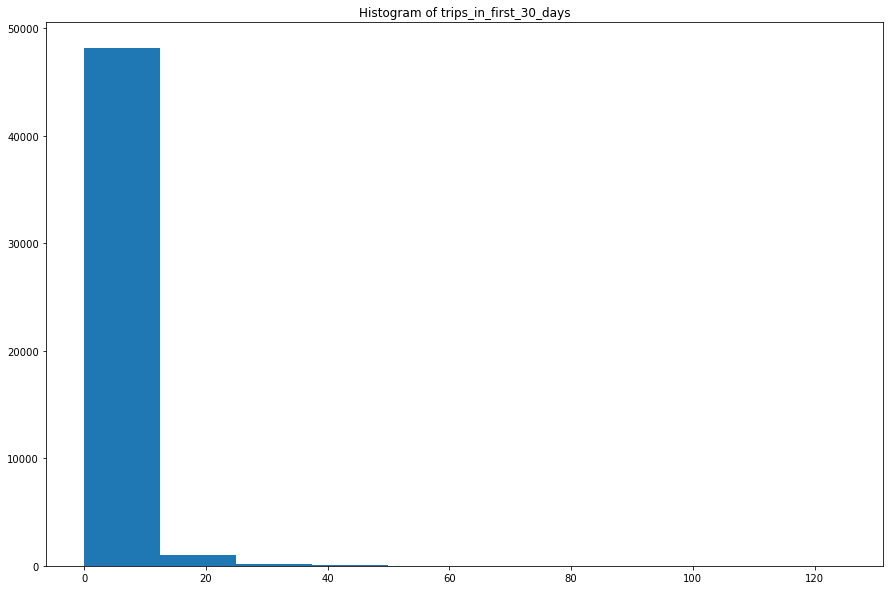

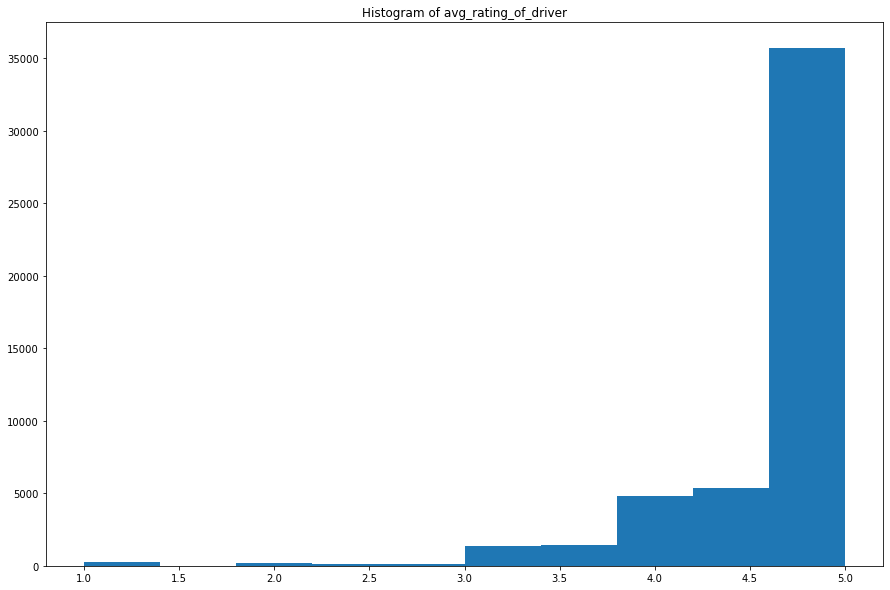

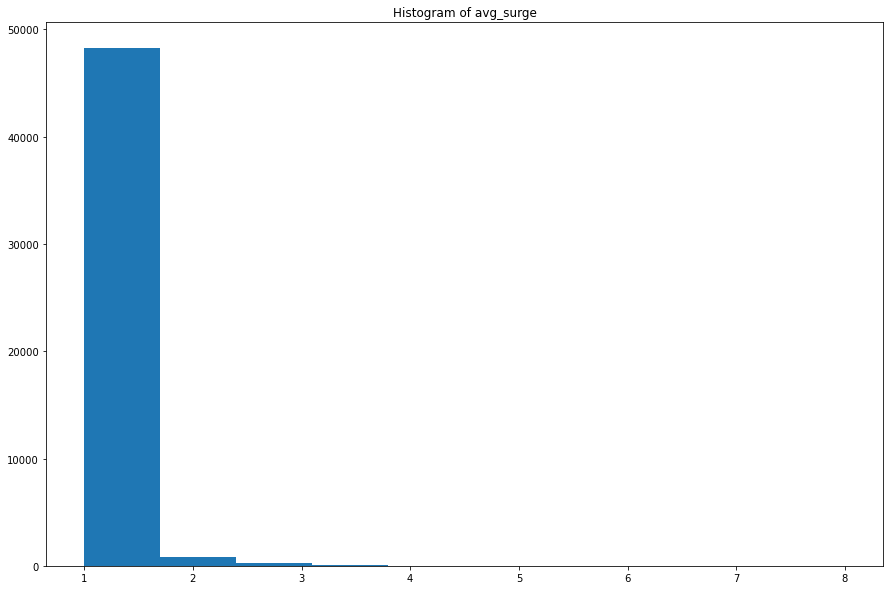

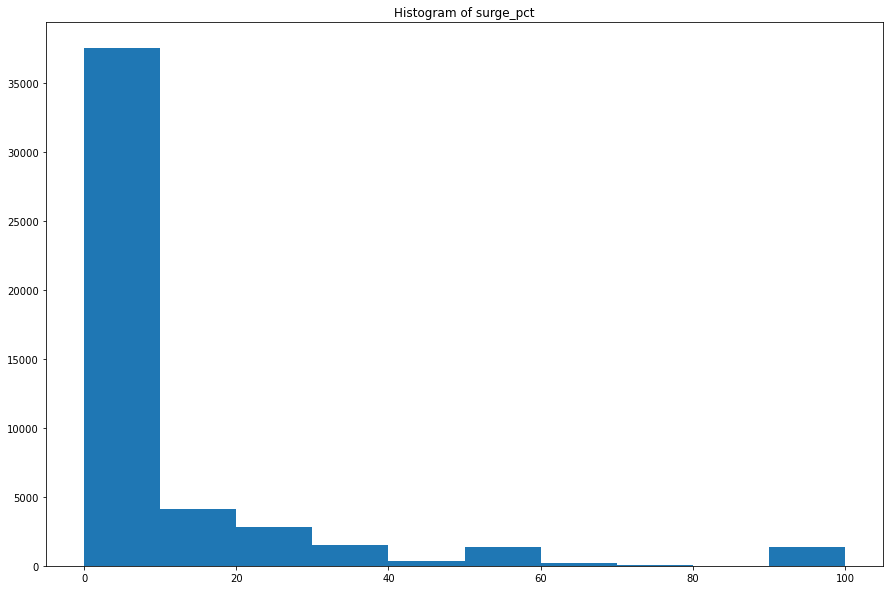

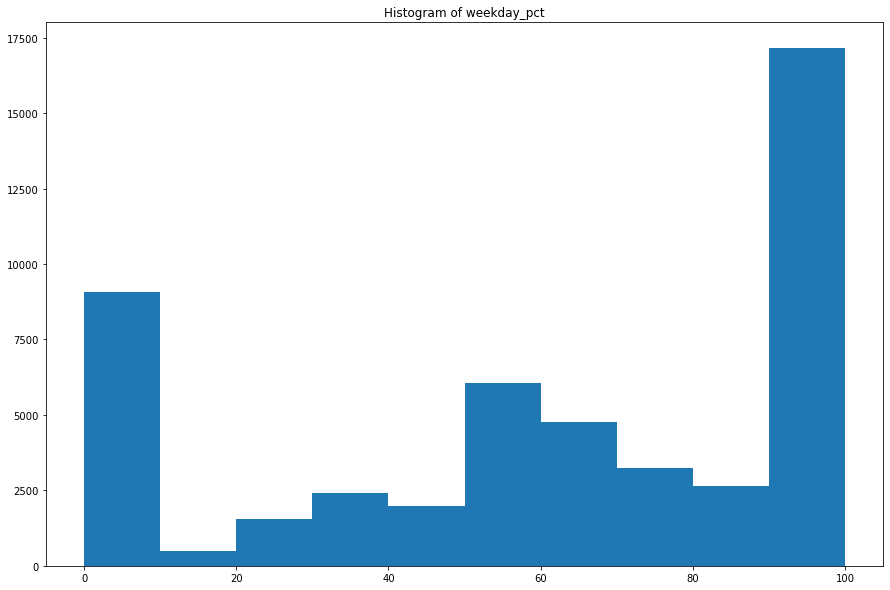

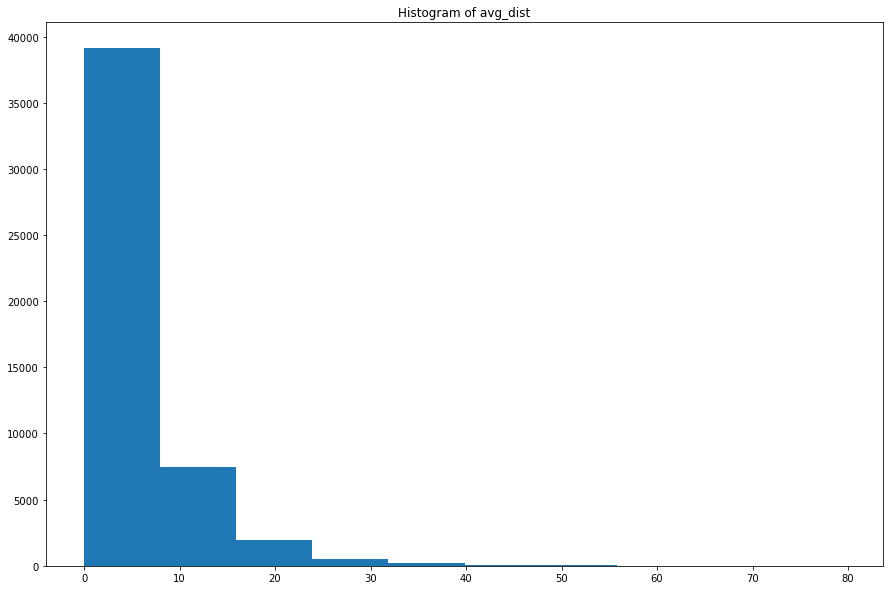

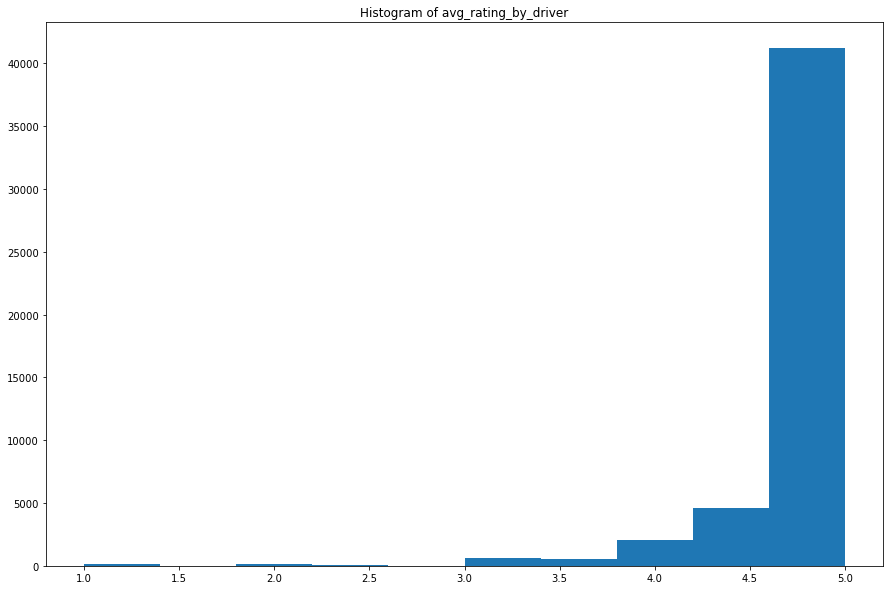

In [136]:
# Plot histograms
for i in plotlist:
    _ = plt.figure(figsize=(15,10))
    _ = plt.hist(data=df, x=i)
    _ = plt.title('Histogram of ' + str(i))
    _ = plt.show()

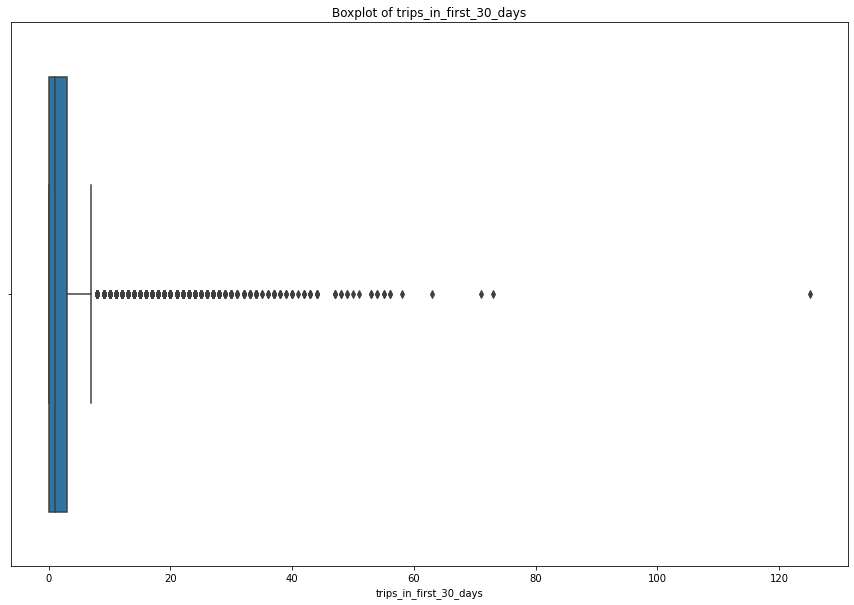

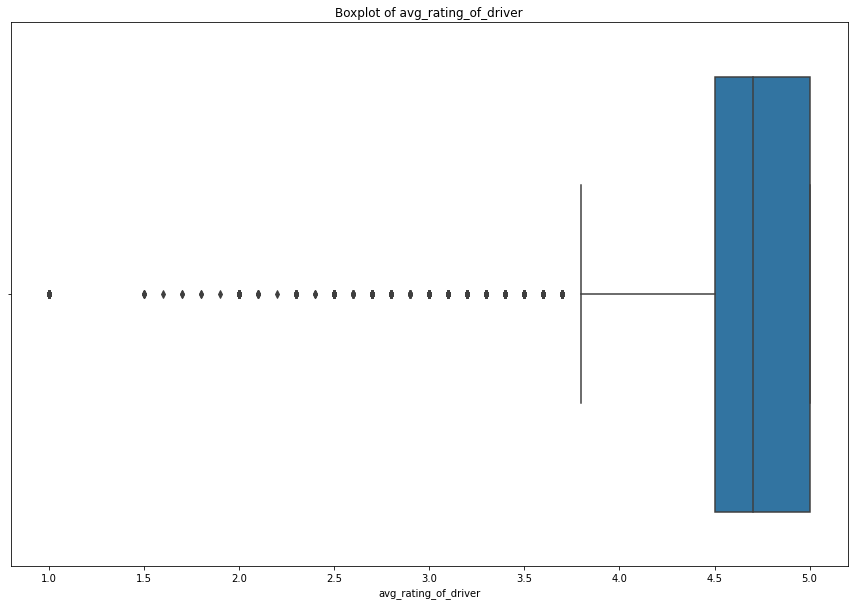

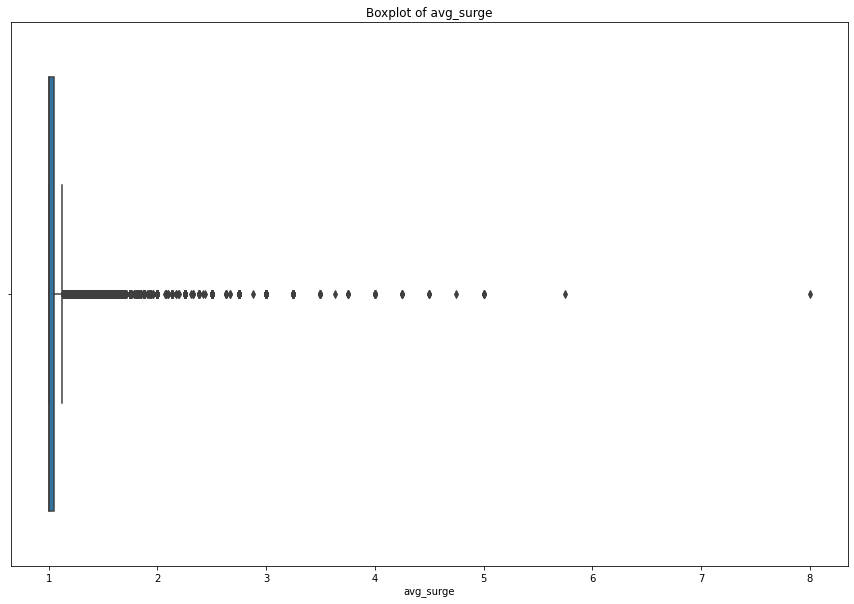

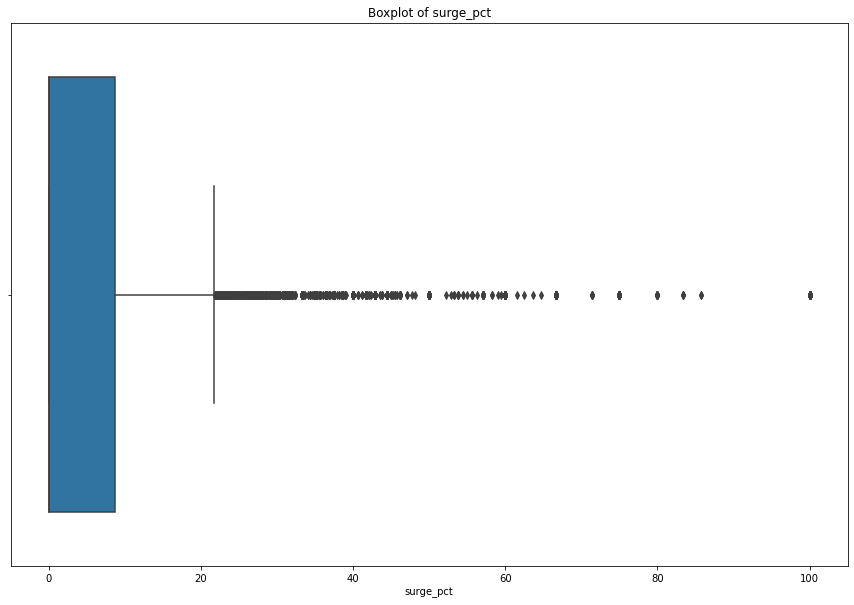

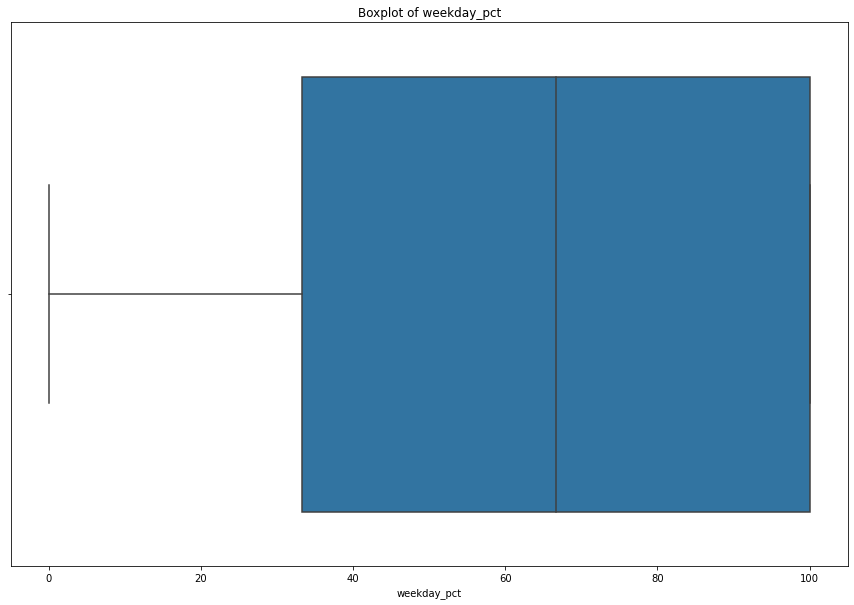

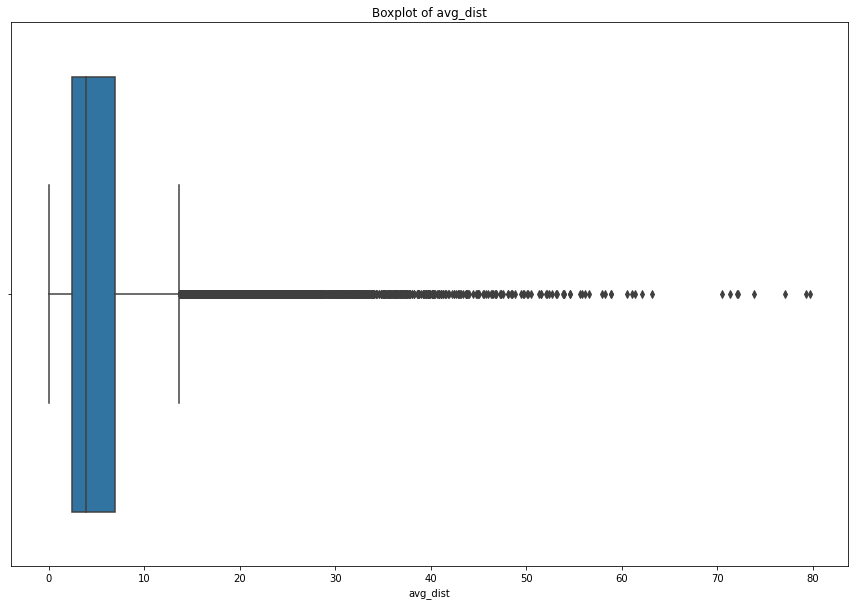

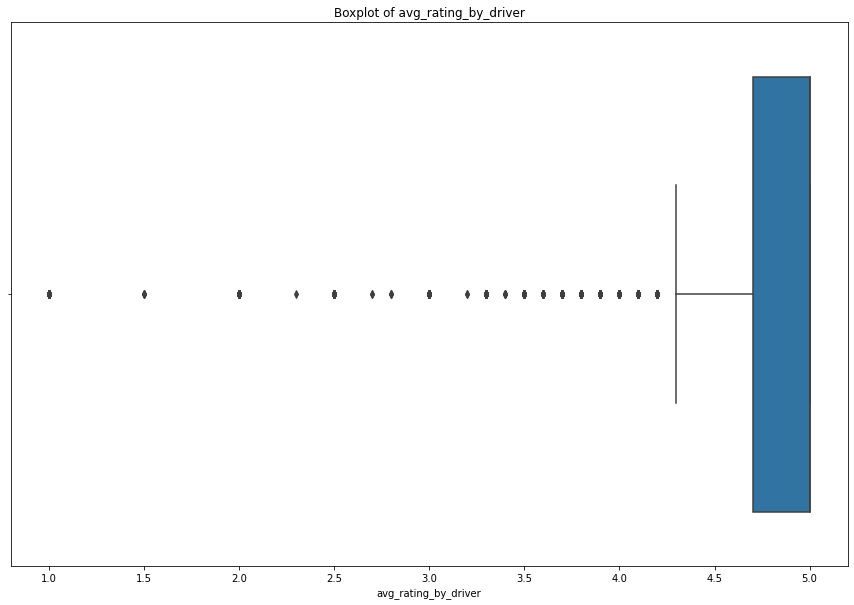

In [140]:
# Plot boxplots
for i in plotlist:
    _ = plt.figure(figsize=(15,10))
    _ = sns.boxplot(data=df, x=i)
    _ = plt.title('Boxplot of ' + str(i))
    _ = plt.show()

These outliers don't seem unbelievable. Keeping outliers for now. Will consider removing them if model performance is subpar.

#### Run pandas_profile

In [141]:
from pandas_profiling import ProfileReport

In [142]:
profile = ProfileReport(df, title="Pandas Profiling Report")

In [143]:
profile